# 0. Hyperparameters
and imports

In [2]:
VIDEO_LENGTH = 20 # seconds
IOU_ASSOCIATION_TRESHOLD = 0.5
CONF_TRESHOLD = 0.2

In [3]:
video_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/'
video = video_folder + 'easy1.mp4'
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/annotations/'
annotations_path = annotations_folder + 'easy1.csv'

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Run Tracking

In [5]:
model_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train4/weights/best.pt'
model = YOLO(model_path)
results = model.track(source=video, persist=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/easy1.mp4: 384x640 (no detections), 112.7ms
video 1/1 (2/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/easy1.mp4: 384x640 (no detections), 6.0ms
video 1/1 (3/598) /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/easy1.mp4: 384x640 (no detections), 5.9ms
video 1/1 (4/598) /vol/bi

# 2. Extract Annotations

In [6]:
def yolo_extract_tracks(results):
  """
  :param results: List of predictions in the format results.bbox = [bbox_xyxy], [confidences], [track_ids]
  """
  bbox_xyxys = []
  confidences = []
  track_ids = []

  for i in range(len(results)):
    bbox_xyxy = []
    confidence = []
    track_id = []
    if results[i].boxes.id is not None:
      bbox_xyxy = results[i].boxes.xyxy.tolist()
      confidence = results[i].boxes.conf.tolist()
      track_id = results[i].boxes.id.tolist()

    bbox_xyxys.append(bbox_xyxy)
    confidences.append(confidence)
    track_ids.append(track_id)

  return [bbox_xyxys, confidences, track_ids]

In [7]:
extracted_pred_results = yolo_extract_tracks(results)

In [8]:
# Load ground truth annotations
annotations = pd.read_csv(annotations_path)
assert all([col in annotations.columns for col in ['track_id', 'video_time', 'frame_id', 'xmin', 'ymin', 'xmax', 'ymax']])

# 3. Align Tracking and Annotations
Annotations are 10fps and Tracking data variable. We need to align them.

In [9]:
def align_annotations_with_predictions_dict_corrected(annotations, track_predictions, video_length):
    """
    Correctly aligns ground truth annotations with predicted data from an object tracking model.
    Each row in the annotations represents a detection, not necessarily a frame.

    :param annotations: DataFrame with ground truth annotations.
    :param track_predictions: List of predictions in the format [[bbox_xyxy], [confidences], [track_ids]]
    :param video_length: Length of the video in seconds.
    :return: List of aligned data in dictionary format.
    """
    # Ground truth frame rate is given as 10 FPS
    gt_frame_rate = 10
    tot_annotation_frames = gt_frame_rate * video_length

    # Calculate the predicted frame rate
    tot_pred_frames = len(track_predictions[0])
    pred_frame_rate = tot_pred_frames / video_length

    assert tot_annotation_frames <= tot_pred_frames # orig video > 10fps

    # Initialize the output list
    results = {
        'gt_bbox_xyxys': [],
        'gt_track_ids': [],
        'pred_bbox_xyxys': [],
        'pred_confidences': [],
        'pred_track_ids': []
    }


    for frame_num in range(tot_annotation_frames):
        ### GET PRED FRAME TRACKS
        # Calculate the corresponding frame in the predictions
        pred_frame_index = int(round(frame_num * pred_frame_rate / gt_frame_rate))
        assert pred_frame_index < tot_pred_frames

        # Extract predicted data for the corresponding frame
        pred_bbox_xyxys = track_predictions[0][pred_frame_index]
        pred_confidences = track_predictions[1][pred_frame_index]
        pred_track_ids = track_predictions[2][pred_frame_index]

        ### GET GT FRAME TRACKS
        # Filter annotations dataframe that has frame_id = frame_num
        frame_annotations = annotations[annotations['frame_id'] == frame_num]

        # Extract ground truth data for the corresponding frame
        gt_track_ids = frame_annotations['track_id'].values.tolist()
        gt_bbox_xyxys = frame_annotations[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

        results['gt_bbox_xyxys'].append(gt_bbox_xyxys)
        results['gt_track_ids'].append(gt_track_ids)
        results['pred_bbox_xyxys'].append(pred_bbox_xyxys)
        results['pred_confidences'].append(pred_confidences)
        results['pred_track_ids'].append(pred_track_ids)

    assert len(results['gt_bbox_xyxys']) == tot_annotation_frames
    assert len(results['gt_track_ids']) == tot_annotation_frames
    assert len(results['pred_bbox_xyxys']) == tot_annotation_frames
    assert len(results['pred_confidences']) == tot_annotation_frames
    assert len(results['pred_track_ids']) == tot_annotation_frames

    return results

In [10]:
aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)

# 4. Evaluate
Calculate `MOTA`, `MOTP`, `IDF1` but also plot the number of ground truth and prediction sharks per frame, with average IDF1 per frame.

> Note: The track ids are not the same as the annotation ids. We need to map them.

In [11]:
def calculate_iou(box_a, box_b):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    boxBArea = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def evaluate_tracking(results, S_TRESH):
    """
    Calculates MOTA, MOTP and IDF1 metrics for a given set of results.
    """
    total_misses = 0
    total_false_positives = 0
    total_mismatches = 0
    total_ground_truth = 0
    frame_avg_motp = [] # Frame sum of IoU / number of GT bboxes in frame
    tot_iou = 0
    idtp = 0
    # This is not counted in MOTA because MOTA focuses on detection
    idf1_extra_fn = 0 # When ID switch, the lost, correct old track is counted as FN
    idf1_extra_fp = 0 # When ID switch, the new tra kis a FP

    id_mapping = {}  # Maps predicted IDs to ground truth IDs
    id_switched = {} # Maps ground truth IDs to predicted IDs before id switch

    tot_frames = len(results['gt_bbox_xyxys'])

    for frame_idx in range(tot_frames):
        gt_bboxes = results['gt_bbox_xyxys'][frame_idx]
        gt_ids = results['gt_track_ids'][frame_idx]
        pred_bboxes = results['pred_bbox_xyxys'][frame_idx]
        pred_ids = results['pred_track_ids'][frame_idx]
        total_ground_truth += len(gt_bboxes)
        frame_tot_iou = 0

        matches = {}  # Maps ground truth IDs to predicted IDs for this frame

        # Find matches and calculate mismatches
        for i, gt_box in enumerate(gt_bboxes):
            gt_id = gt_ids[i]
            best_iou = S_TRESH
            best_pred_idx = -1

            for j, pred_box in enumerate(pred_bboxes):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_pred_idx = j

            if best_pred_idx != -1:
                pred_id = pred_ids[best_pred_idx]
                matches[gt_id] = pred_id
                frame_tot_iou += best_iou

                if gt_id in id_switched:
                    if id_switched[gt_id] != pred_id:
                        idf1_extra_fn += 1
                        idf1_extra_fp += 1
                    else:
                        # recovered track
                        del id_switched[gt_id]
                    
                # Check for identity switch or fragmentation
                if gt_id in id_mapping and id_mapping[gt_id] != pred_id:
                    # id switch
                    total_mismatches += 1
                    if gt_id not in id_switched:
                      id_switched[gt_id] = id_mapping[gt_id]
                id_mapping[gt_id] = pred_id

        # Calculate false positives and misses
        total_false_positives += len(pred_bboxes) - len(matches)
        idtp += len(matches)
        total_misses += len(gt_bboxes) - len(matches)
        # Calculate MOTP
        avg_motp = frame_tot_iou / len(gt_bboxes) if len(gt_bboxes) > 0 else None
        frame_avg_motp.append(avg_motp) 
        tot_iou += frame_tot_iou

    mota = 1 - (total_misses + total_false_positives + total_mismatches) / total_ground_truth
    motp = tot_iou / total_ground_truth

    # Calculate IDF1
    idfn = total_misses + idf1_extra_fn
    idfp = total_false_positives + idf1_extra_fp
    idf1 = idtp / (idtp + 0.5 * idfn + 0.5 * idfp)

    return mota, motp, idf1, frame_avg_motp


In [12]:
mota, motp, idf1, frame_avg_motp = evaluate_tracking(aligned_annotations, IOU_ASSOCIATION_TRESHOLD)

# 5. Show results

In [13]:
def plot_performance_graph(aligned_annotations, motp_per_frame):
    """
    Plots number of ground truth tracks vs number of predicted tracks for each frame,
    along with the MOTP for frames where it's available.
    """
    gt_track_ids = aligned_annotations['gt_track_ids']
    pred_track_ids = aligned_annotations['pred_track_ids']

    gt_track_ids_count = [len(x) for x in gt_track_ids]
    pred_track_ids_count = [len(x) for x in pred_track_ids]

    # Filter out None values from MOTP list and get corresponding frame numbers
    motp_values = [motp for motp in motp_per_frame if motp is not None]
    motp_frames = [i for i, motp in enumerate(motp_per_frame) if motp is not None]

    plt.figure(figsize=(10, 6))
    plt.plot(gt_track_ids_count, label='Ground Truth')
    plt.plot(pred_track_ids_count, label='Predictions')
    plt.plot(motp_frames, motp_values, label='Frame-Avg MOTP', linestyle='-',)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Tracks / MOTP')
    plt.legend()
    plt.show()

MOTA: 0.67, MOTP: 0.55, IDF1: 0.66


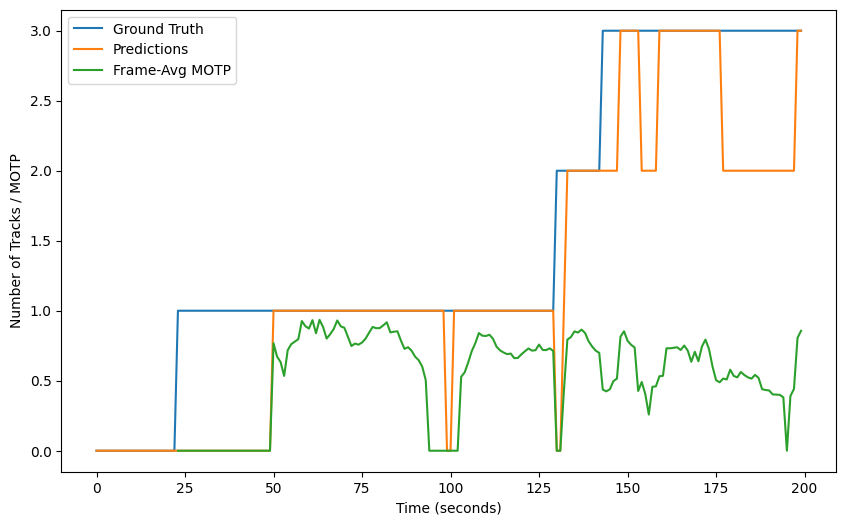

In [14]:
print(f'MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
plot_performance_graph(aligned_annotations, frame_avg_motp)

# 6. Investigate
For frames with poor graph performance, show the GT and PRED bounding boxes

In [15]:
import cv2
import numpy as np

def draw_bbox(img, gt_bbox, pred_bbox):
  color1 = (0, 255, 0)
  color2 = (0, 0, 255)

  for bbox in gt_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color1, int(max(img.shape[:2]) / 200))

  for bbox in pred_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color2, int(max(img.shape[:2]) / 200))

  # Add legend for color
  img = cv2.putText(img, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color1, 2, cv2.LINE_AA)
  img = cv2.putText(img, 'Predictions', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 2, cv2.LINE_AA)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)


def plot_frame(video, frame_num, aligned_annotations):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  gt_bbox = aligned_annotations['gt_bbox_xyxys'][frame_num]
  pred_bbox = aligned_annotations['pred_bbox_xyxys'][frame_num]

  # Convert frame number to timestamp (in milliseconds)
  timestamp = (frame_num / 10) * 1000  # frame_num / fps * 1000

  # Extract the frame from the video at the specific timestamp
  cap = cv2.VideoCapture(video)
  cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  ret, frame = cap.read()
  cap.release()

  print(ret)

  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, gt_bbox, pred_bbox)

True


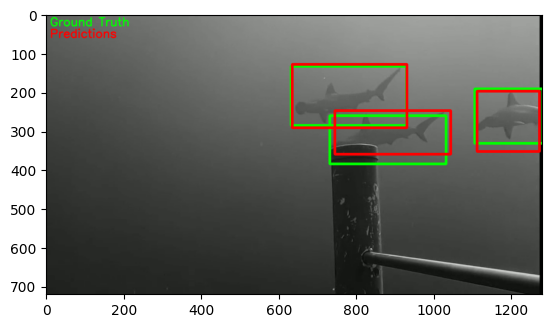

In [17]:
frame_to_inspect = 150
plot_frame(video, frame_to_inspect, aligned_annotations)

# 7. Bulk-Test all videos

In [18]:
video_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/'
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/annotations/'
model_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt'

testing model /vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt
Evaluating medium1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium1.mp4 - MOTA: 0.28, MOTP: 0.26, IDF1: 0.43


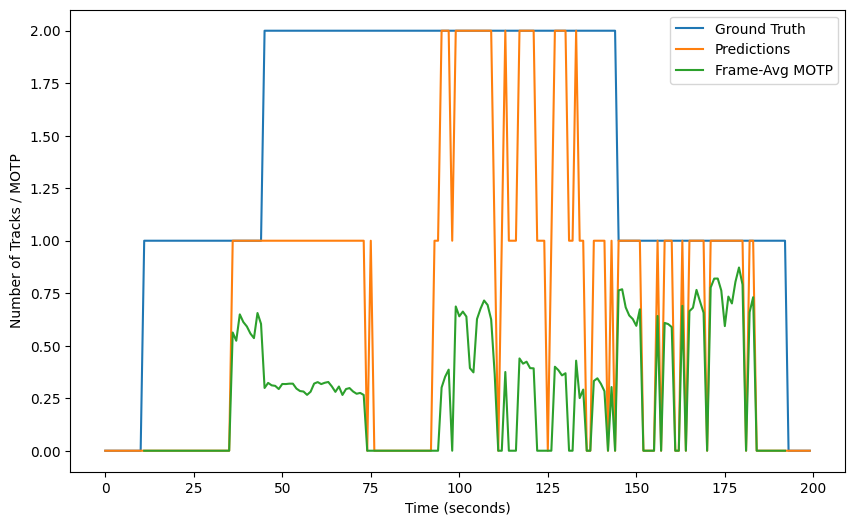

Evaluating easy1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy1.mp4 - MOTA: 0.78, MOTP: 0.63, IDF1: 0.69


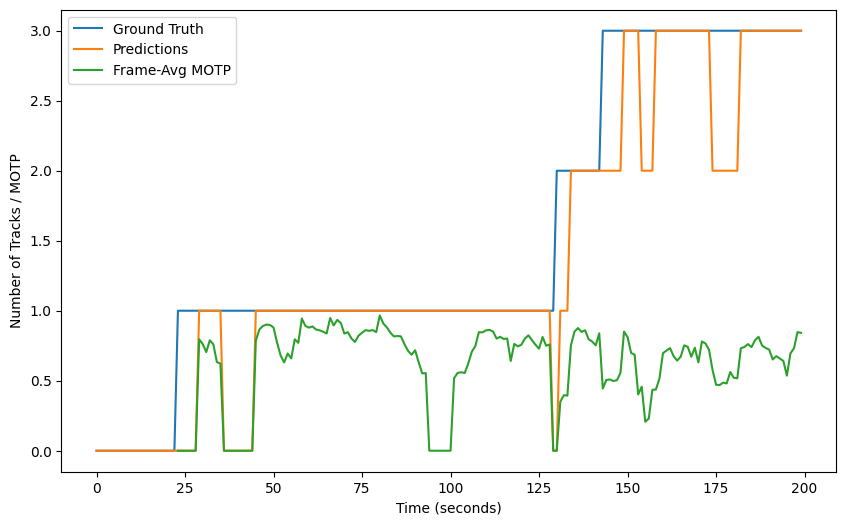

Evaluating difficult2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult2.mp4 - MOTA: 0.27, MOTP: 0.29, IDF1: 0.41


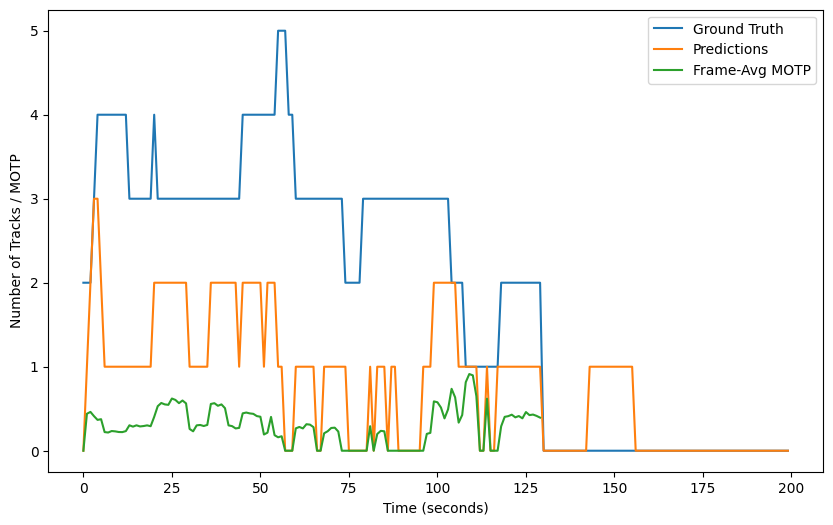

Evaluating difficult1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult1.mp4 - MOTA: 0.21, MOTP: 0.17, IDF1: 0.35


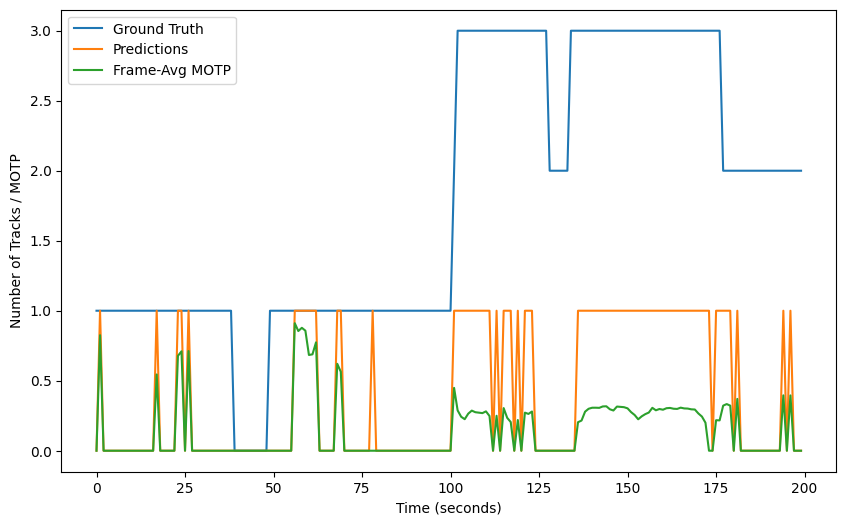

Evaluating easy2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy2.mp4 - MOTA: 0.72, MOTP: 0.6, IDF1: 0.76


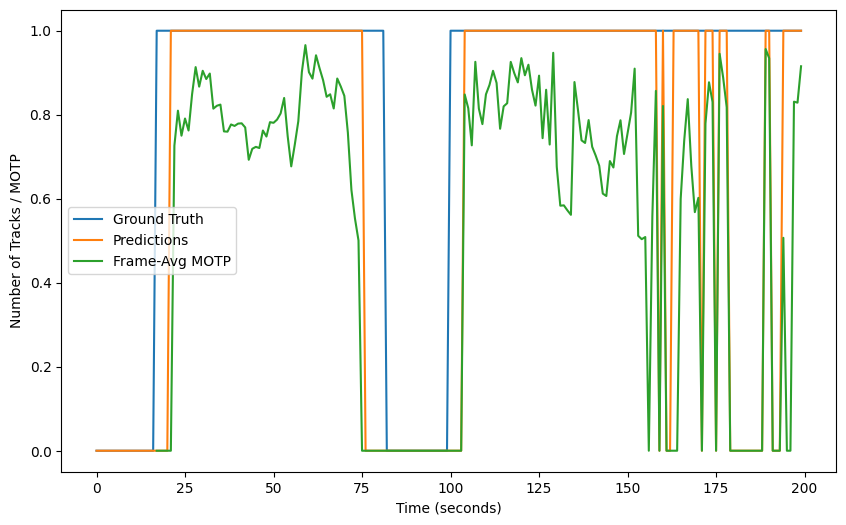

Evaluating medium2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium2.mp4 - MOTA: 0.33, MOTP: 0.27, IDF1: 0.5


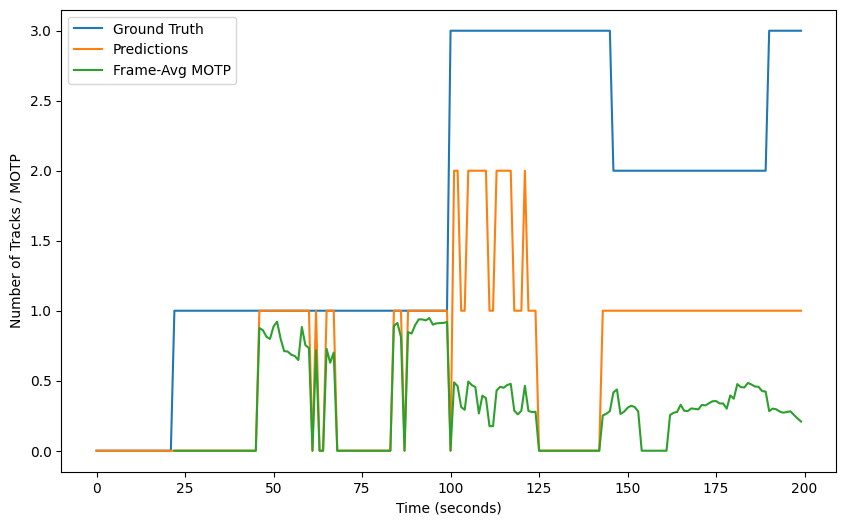

Avg results: MOTA: 0.43, MOTP: 0.37, IDF1: 0.52


In [20]:
videos = os.listdir(video_folder)
print('testing model ' + model_path)
model = YOLO(model_path)

motas = []
motps = []
idf1s = []

for video in videos:
  print(f'Evaluating {video}')
  video_path = video_folder + video
  annotations_path = annotations_folder + video[:-4] + '.csv'
  annotations = pd.read_csv(annotations_path)
  results = model.track(source=video_path, persist=True, conf=CONF_TRESHOLD, verbose=False)
  extracted_pred_results = yolo_extract_tracks(results)
  aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)
  mota, motp, idf1, frame_avg_motp = evaluate_tracking(aligned_annotations, IOU_ASSOCIATION_TRESHOLD)
  motas.append(mota)
  motps.append(motp)
  idf1s.append(idf1)
  print(f'{video} - MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
  plot_performance_graph(aligned_annotations, frame_avg_motp)

print(f'Avg results: MOTA: {round(np.mean(motas), 2)}, MOTP: {round(np.mean(motps), 2)}, IDF1: {round(np.mean(idf1s), 2)}')